# Final Project: CVA Multicurve
### Group 1b: Artioli Fiammetta, Cantù Davide, Frigerio Giorgio Pietro

In [1]:
import numpy as np
from bootstrap import *
from swap import *
from swaption import surf_plot
from readExcelData import *
from HW_tree import *
from jamshidian import *

In [2]:
# Reading data from Excel (24 Jun 2022)
N_sheet_1 = '24 Jun 2022'
N_sheet_2 = '31 Jan 2023'
formatData = '%Y-%m-%d %H:%M:%S'
data_24_jun = readExcelData('CVAProjectMktData.xlsx',formatData,N_sheet_1)

## Exercise 1: Multicurve calibration
#### Reference date: 24 Jun 2022

In [3]:
[discount_dates_24_jun, discount_curve_24_jun, P_dates_24_jun, P_curve_24_jun] = bootstrap_dual_curve(data_24_jun)

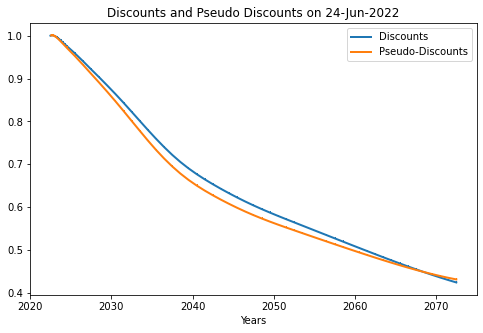

In [4]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot_date(discount_dates_24_jun, discount_curve_24_jun, fmt=",-", linewidth=2)
ax.plot_date(P_dates_24_jun, P_curve_24_jun, fmt=",-", linewidth=2)

ax.set_xlabel('Years')
ax.legend(['Discounts', 'Pseudo-Discounts'])
ax.set_title("Discounts and Pseudo Discounts on 24-Jun-2022");

## Exercise 2: Risk Free Amortizing Swap Pricing

In [5]:
# Reading swap data from excel 24 Jun 2022
SwapData = readExcelData_SwapAnnex('SwapAmortizingPlan.xlsx', '%Y-%m-%d %H:%M:%S')

In [6]:
# Swap pricing risk free 24 Jun 2022
K = 0.0221                                      # strike
settle_1 = data_24_jun['settlement']            # settlement date for 24 jun 2022 case
Initial_Notional = SwapData['Notionals'][0]     # initial notional

In [7]:
# discounts, pseudo-discounts and forward pseudo-discounts for swap
B_24_jun, Bp_24_jun, Bp_fwd_24_jun = swap_discounts(settle_1,discount_dates_24_jun,discount_curve_24_jun,P_dates_24_jun,P_curve_24_jun,SwapData['EndDates'])

# swap NPV risk free (only fixed leg amortizing case)
NPV_SA_risk_free_24_jun = swap_pricing_risk_free(SwapData['StartDates'],SwapData['EndDates'],B_24_jun,Bp_fwd_24_jun,SwapData['Notionals'],Initial_Notional,K,"SA");

# swap NPV risk free (both legs amortizing case)
NPV_DA_risk_free_24_jun = swap_pricing_risk_free(SwapData['StartDates'],SwapData['EndDates'],B_24_jun,Bp_fwd_24_jun,SwapData['Notionals'],Initial_Notional,K,"DA");

## Exercise 3: Amortizing Swap Pricing with CVA

In [8]:
# Reading swaption data from excel 24 Jun 2022
VolData_1 = readExcelData_SwaptionVol('CVAProjectMktData.xlsx',formatData,N_sheet_1)

# Swap pricing with CVA 24 Jun 2022
LGD = 0.40                              # loss given default
spreads = np.array([300, 500])*1e-4     # vector of spreads
freq = 4                                # yearly payment frequency
swap_maturity = 15                      # swap maturity in years

# probabilities, betas and deltas for swap pricing with CVA
Prob_24_jun, beta_24_jun, deltas_24_jun = swap_elements(Bp_24_jun,B_24_jun,SwapData['PayDates'],settle_1,spreads,LGD)

# interpolated volatilities
vol_SA_24_jun = vol_interp(settle_1,SwapData['Notionals'],Initial_Notional,discount_dates_24_jun,discount_curve_24_jun,B_24_jun,
                           SwapData['PayDates'],VolData_1['expiry'],VolData_1['tenor'],freq,swap_maturity,VolData_1['vol'],"SA");
vol_DA_24_jun = vol_interp(settle_1,SwapData['Notionals'],Initial_Notional,discount_dates_24_jun,discount_curve_24_jun,B_24_jun,
                           SwapData['PayDates'],VolData_1['expiry'],VolData_1['tenor'],freq,swap_maturity,VolData_1['vol'],"DA");

# swap NPVs with CVA (only fixed leg amortizing case)
NPVs_CVA_SA_24_jun = swap_pricing_CVA(Prob_24_jun,beta_24_jun,deltas_24_jun,NPV_SA_risk_free_24_jun,vol_SA_24_jun,settle_1,SwapData['PayDates'],B_24_jun,SwapData['Notionals'],Initial_Notional,K,LGD,"SA")

# swap NPVs with CVA (both legs amortizing case)
NPVs_CVA_DA_24_jun = swap_pricing_CVA(Prob_24_jun,beta_24_jun,deltas_24_jun,NPV_DA_risk_free_24_jun,vol_DA_24_jun,settle_1,SwapData['PayDates'],B_24_jun,SwapData['Notionals'],Initial_Notional,K,LGD,"DA")

## Exercise 4: Unwinding

In [9]:
# Bootstrap 31 Jan 2023
data_31_jan = readExcelData('CVAProjectMktData.xlsx',formatData,N_sheet_2)
[discount_dates_31_jan, discount_curve_31_jan, P_dates_31_jan, P_curve_31_jan] = bootstrap_dual_curve(data_31_jan)

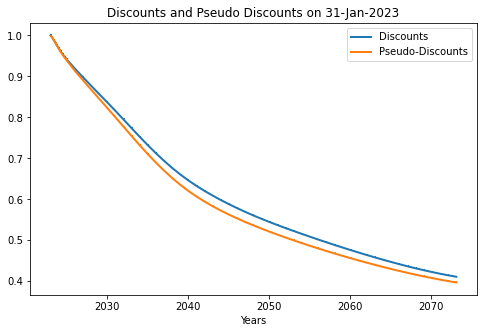

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot_date(discount_dates_31_jan, discount_curve_31_jan, fmt=",-", linewidth=2)
ax.plot_date(P_dates_31_jan, P_curve_31_jan, fmt=",-", linewidth=2)

ax.set_xlabel('Years')
ax.legend(['Discounts', 'Pseudo-Discounts'])
ax.set_title("Discounts and Pseudo Discounts on 31-Jan-2023");

In [11]:
# Reading swaption data from excel 31 Jan 2023
VolData_2 = readExcelData_SwaptionVol('CVAProjectMktData.xlsx',formatData,N_sheet_2)

# Swap pricing risk free (unwinding at 31 Jan 2023)
settle_2 = data_31_jan['settlement']                            # settlement date for 31 jan 2023 case
Euribor_28_12 = 0.02202                                         # Euribor 3m on 28 dec 2022 from market data
idx = np.argwhere(settle_2<SwapData['EndDates']).flatten()      # indexes of dates of interest

# discounts, pseudo-discounts and forward pseudo-discounts for swap
B_31_jan, Bp_31_jan, Bp_fwd_31_jan = swap_discounts_modified(settle_2,discount_dates_31_jan,discount_curve_31_jan,P_dates_31_jan,P_curve_31_jan,SwapData['StartDates'],SwapData['EndDates'],Euribor_28_12,idx)

# swap NPV risk free (only fixed leg amortizing case)
NPV_SA_risk_free_31_jan = swap_pricing_risk_free(SwapData['StartDates'][idx],SwapData['EndDates'][idx],B_31_jan,Bp_fwd_31_jan,SwapData['Notionals'][idx],Initial_Notional,K,"SA")

# swap NPV risk free (both legs amortizing case)
NPV_DA_risk_free_31_jan = swap_pricing_risk_free(SwapData['StartDates'][idx],SwapData['EndDates'][idx],B_31_jan,Bp_fwd_31_jan,SwapData['Notionals'][idx],Initial_Notional,K,"DA")

# Swap pricing with CVA (unwinding at 31 Jan 2023)
swap_maturity_new = swap_maturity - idx[0]/freq           # new swap maturity in years

# probabilities, betas and deltas for swap pricing with CVA
Prob_31_jan, beta_31_jan, deltas_31_jan = swap_elements(Bp_31_jan,B_31_jan,SwapData['PayDates'][idx],settle_2,spreads,LGD)

In [12]:
# interpolated volatilities
vol_SA_31_jan = vol_interp(settle_2,SwapData['Notionals'][idx],Initial_Notional,discount_dates_31_jan,discount_curve_31_jan,
                B_31_jan,SwapData['PayDates'][idx],VolData_2['expiry'],VolData_2['tenor'],freq,swap_maturity_new,VolData_2['vol'],"SA")
vol_DA_31_jan = vol_interp(settle_2,SwapData['Notionals'][idx],Initial_Notional,discount_dates_31_jan,discount_curve_31_jan,
                B_31_jan,SwapData['PayDates'][idx],VolData_2['expiry'],VolData_2['tenor'],freq,swap_maturity_new,VolData_2['vol'],"DA")

# swap NPVs with CVA (only fixed leg amortizing case)
NPVs_CVA_SA_31_jan = swap_pricing_CVA(Prob_31_jan,beta_31_jan,deltas_31_jan,NPV_SA_risk_free_31_jan,vol_SA_31_jan,settle_2,
                                      SwapData['PayDates'][idx],B_31_jan,SwapData['Notionals'][idx],Initial_Notional,K,LGD,"SA")

# swap NPVs with CVA (both legs amortizing case)
NPVs_CVA_DA_31_jan = swap_pricing_CVA(Prob_31_jan,beta_31_jan,deltas_31_jan,NPV_DA_risk_free_31_jan,vol_DA_31_jan,settle_2,
                                      SwapData['PayDates'][idx],B_31_jan,SwapData['Notionals'][idx],Initial_Notional,K,LGD,"DA")

## Exercise 5: Calibration Multicurve Swaption model 

In [13]:
# settings for model calibration
gamma = np.array([0, 0.5, 1])                # fixed values of gamma
expiries = np.array([1,3,5,8,10,12,15])      # expiries of the considered swaptions for the calibration
tenors = np.array([15,12,10,7,5,3,1])        # tenors of the considered swaptions for the calibration
init_cond_24_jun = np.array([0.001, 0.0094]) # initial conditions for 24 June 2022 
init_cond_31_jan = np.array([0.005, 0.005])  # initial conditions for 31 January 2023

# volatilities for calibration
vol_cal_24_jun = readExcelData_vol_calibration('CVAProjectMktData.xlsx',N_sheet_1,expiries,tenors).flatten()
vol_cal_31_jan = readExcelData_vol_calibration('CVAProjectMktData.xlsx',N_sheet_2,expiries,tenors).flatten()


# Model Calibration considering Receiver swaptions at 24 June 2022
parameters_24_jun_Receiver = np.array([ModelCalibration_Receiver(x,K,discount_dates_24_jun, discount_curve_24_jun,P_dates_24_jun,
                                P_curve_24_jun,settle_1,expiries,tenors,freq,vol_cal_24_jun, init_cond_24_jun) for x in gamma])

#  Model Calibration considering Receiver swaptions at 31 January 2023
parameters_31_jan_Receiver = np.array([ModelCalibration_Receiver(x,K,discount_dates_31_jan, discount_curve_31_jan,P_dates_31_jan,
                                P_curve_31_jan,settle_2,expiries,tenors,freq,vol_cal_31_jan, init_cond_31_jan) for x in gamma])

# Model Calibration considering Payer swaptions at 24 June 2022
parameters_24_jun_Payer = np.array([ModelCalibration_Payer(x,K,discount_dates_24_jun, discount_curve_24_jun,P_dates_24_jun,
                                    P_curve_24_jun,settle_1,expiries,tenors,freq,vol_cal_24_jun,init_cond_24_jun) for x in gamma])

# Model Calibration considering Payer swaptions at 31 January 2023
parameters_31_jan_Payer = np.array([ModelCalibration_Payer(x,K,discount_dates_31_jan, discount_curve_31_jan,P_dates_31_jan,
                                   P_curve_31_jan,settle_2,expiries,tenors,freq,vol_cal_31_jan,init_cond_31_jan) for x in gamma])

C:\Users\Utente\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


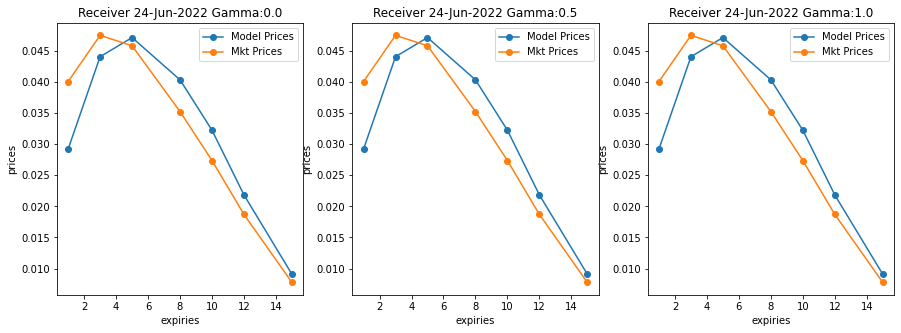

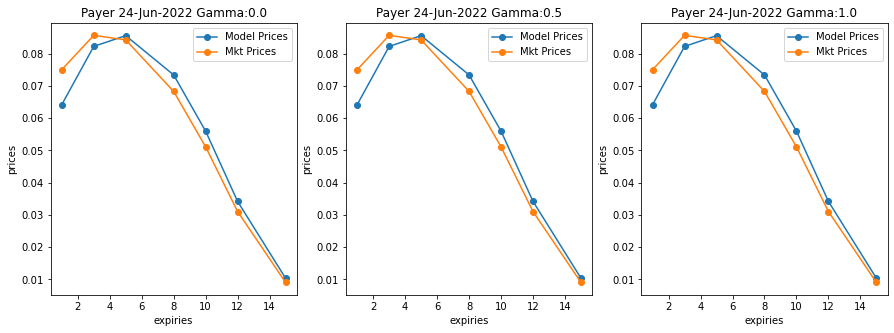

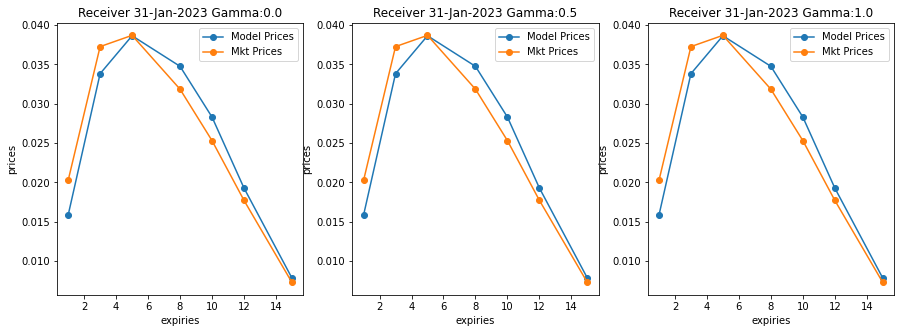

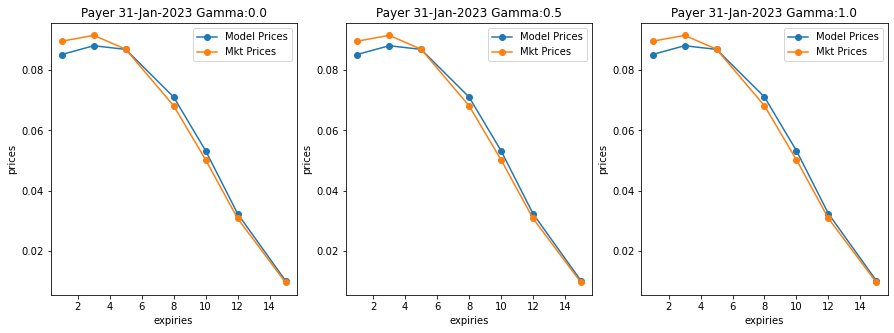

In [14]:
# Comparison of model and market prices for the calibrated parameters:

# Receiver 24-Jun-2022
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i in range(len(gamma)):
    ax[i].plot(expiries, parameters_24_jun_Receiver[0]["model"], linestyle='-', marker='o')
    ax[i].plot(expiries, parameters_24_jun_Receiver[0]["mkt"], linestyle='-', marker='o')
    ax[i].legend(['Model Prices', 'Mkt Prices'])
    ax[i].set_title("Receiver 24-Jun-2022 Gamma:{}".format(gamma[i]))
    ax[i].set_xlabel('expiries')
    ax[i].set_ylabel('prices')

# Payer 24-Jun-2022
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i in range(len(gamma)):
    ax[i].plot(expiries, parameters_24_jun_Payer[0]["model"], linestyle='-', marker='o')
    ax[i].plot(expiries, parameters_24_jun_Payer[0]["mkt"], linestyle='-', marker='o')
    ax[i].legend(['Model Prices', 'Mkt Prices'])
    ax[i].set_title("Payer 24-Jun-2022 Gamma:{}".format(gamma[i]))
    ax[i].set_xlabel('expiries')
    ax[i].set_ylabel('prices')

# Receiver 31-Jan-2023
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i in range(len(gamma)):
    ax[i].plot(expiries, parameters_31_jan_Receiver[0]["model"], linestyle='-', marker='o')
    ax[i].plot(expiries, parameters_31_jan_Receiver[0]["mkt"], linestyle='-', marker='o')
    ax[i].legend(['Model Prices', 'Mkt Prices'])
    ax[i].set_title("Receiver 31-Jan-2023 Gamma:{}".format(gamma[i]))
    ax[i].set_xlabel('expiries')
    ax[i].set_ylabel('prices')

# Receiver 31-Jan-2023
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i in range(len(gamma)):
    ax[i].plot(expiries, parameters_31_jan_Payer[0]["model"], linestyle='-', marker='o')
    ax[i].plot(expiries, parameters_31_jan_Payer[0]["mkt"], linestyle='-', marker='o')
    ax[i].legend(['Model Prices', 'Mkt Prices'])
    ax[i].set_title("Payer 31-Jan-2023 Gamma:{}".format(gamma[i]))
    ax[i].set_xlabel('expiries')
    ax[i].set_ylabel('prices')

The minimization algorithm "scipy.optimize.minimize" is highly dependent on the initial condition. This behaviour can be explained by the fact that there are multiple local minima to which the algorithm can converge. Indeed plotting the distance as a function of the parameters a and sigma it's possible to observe that within a correct range of sigma, it's possible to achieve very close values of distance with a wide range of values of a

In [15]:
# Surface plot of the distance as a function of parameters a and sigma in the case of a Payer and market data with reference date 24-Jun-2022 
# for gamma=0

X, Y, Z = surf_plot(gamma[0],K,discount_dates_24_jun, discount_curve_24_jun,P_dates_24_jun,P_curve_24_jun,settle_1,
                    expiries,tenors,freq,vol_cal_24_jun,init_cond_24_jun)

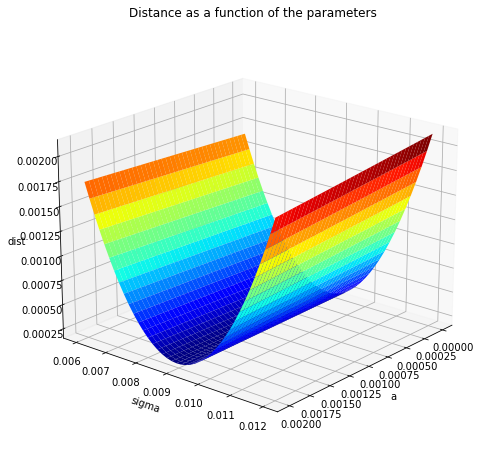

In [16]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='jet')
ax.set_xlabel('a')
ax.set_ylabel('sigma')
ax.set_zlabel('dist')
ax.set_title('Distance as a function of the parameters')
ax.view_init(elev=20, azim=40)  

## Exercise 6: Amortizing Swap Pricing with CVA by using numerical techniques

In [17]:
# NPV with CVA with alternative approaches assuming Gamma = 0
month_steps = 6
# The chosen parameters are the ones minimizing the distance by using the algorithm scipy.optimize.minimize with the initial conditions above (slightly different from Matlab's ones)
a = parameters_24_jun_Payer[0]['Params'][0]
sigma = parameters_24_jun_Payer[0]['Params'][1]

# Model used for the calibration
NPVs_CVA_SA_Model = swap_pricing_CVA_Payer_Model(Prob_24_jun,beta_24_jun,NPV_SA_risk_free_24_jun,settle_1,SwapData['PayDates'],
                        B_24_jun,SwapData['Notionals'],Initial_Notional,K,LGD,a,sigma,"SA")
NPVs_CVA_DA_Model = swap_pricing_CVA_Payer_Model(Prob_24_jun,beta_24_jun,NPV_DA_risk_free_24_jun,settle_1,SwapData['PayDates'],
                        B_24_jun,SwapData['Notionals'],Initial_Notional,K,LGD,a,sigma,"DA")

In [18]:
# Generalized trinomial Tree
NPVs_CVA_SA_tree = swap_pricing_tree(Prob_24_jun,beta_24_jun,NPV_SA_risk_free_24_jun,swap_maturity,settle_1,SwapData['PayDates'],
                                SwapData['Notionals'],Initial_Notional,K,a,sigma,discount_dates_24_jun,discount_curve_24_jun,freq,month_steps,LGD,"SA")
NPVs_CVA_DA_tree = swap_pricing_tree(Prob_24_jun,beta_24_jun,NPV_DA_risk_free_24_jun,swap_maturity,settle_1,SwapData['PayDates'],
                                SwapData['Notionals'],Initial_Notional,K,a,sigma,discount_dates_24_jun,discount_curve_24_jun,freq,month_steps,LGD,"DA")

In [19]:
# Jamshidian approach
NPVs_CVA_SA_Jam = swap_pricing_jamshidian(Prob_24_jun,beta_24_jun,NPV_SA_risk_free_24_jun,swap_maturity,settle_1,SwapData['PayDates'],SwapData['Notionals'],
                    Initial_Notional,K,a,sigma,discount_dates_24_jun,discount_curve_24_jun,freq,LGD,"SA")
NPVs_CVA_DA_Jam = swap_pricing_jamshidian(Prob_24_jun,beta_24_jun,NPV_DA_risk_free_24_jun,swap_maturity,settle_1,SwapData['PayDates'],SwapData['Notionals'],
                    Initial_Notional,K,a,sigma,discount_dates_24_jun,discount_curve_24_jun,freq,LGD,"DA")